In [1]:
import modelbase 
import modelbase.ratelaws as rl
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Could not load modelbase.assimulate. Sundials support disabled.


# Brusselator

The phenomenon of chemical oscillations can be described by the following reactions

\begin{equation}
A \rightarrow X, \quad v_1 = A
\end{equation}
\begin{equation}
2X+Y \rightarrow 3X, \quad v_2 = X^{2}Y
\end{equation}
\begin{equation}
X+B \rightarrow Y, \quad v_3 = BX
\end{equation}
\begin{equation}
X \rightarrow \emptyset, \quad v_4 = X
\end{equation}



The "Brusselator" model, consisting of following ordinary differential equations:
\begin{eqnarray}
  \frac{dX}{dt} &=& A - BX + X^{2}Y - X \\
  \frac{dY}{dt} &=& BX - X^{2}Y
\end{eqnarray}
Where the chemical species $A$ and $B$ can be considered as constants.

### Exercise 1: Implement and simulate the ODE system over time using the constants 
\begin{equation}
  A=1\quad\mathrm{and}\quad B=1.7
\end{equation}
### Exercise 2: Implement and simulate the ODE system over time using the constants 
\begin{equation}
  A=1\quad\mathrm{and}\quad B=3
\end{equation}
### Exercise 3: Plot the trajectories of each simulation

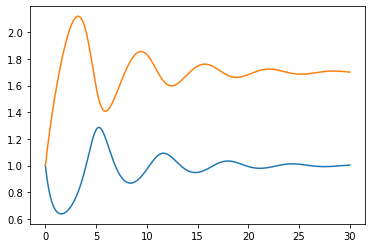

OK!


In [2]:
import matplotlib.pyplot as plt
import numpy as np
import modelbase


p = {
                    'A':1,
                    'B':1.7}

m = modelbase.Model(p)

cl=['X','Y']
    
m.set_cpds(cl)

def v1(p):
    return p.A

m.set_rate('v1',v1) 
m.set_stoichiometry('v1',{'X':1}) 

def v2(p,X):
    return p.B*X

m.set_rate('v2',v2,'X') 
m.set_stoichiometry('v2',{'X':-1,'Y':1}) 

def v3(p,X,Y):
    return X**2*Y

m.set_rate('v3',v3,'X','Y') 
m.set_stoichiometry('v3',{'X':1,'Y':-1}) 


def v4(p,X):
    return X

m.set_rate('v4',v4,'X') 
m.set_stoichiometry('v4',{'X':-1}) 



s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,30,500),[1,1])

plt.figure()
plt.plot(s.getT(),s.getY())
plt.draw_if_interactive()
plt.show()

print("OK!")



# Signalling cascades
A weakly activated signalling cascade of kinases can be described by the following ordinary differential equations:
\begin{eqnarray}
  \frac{dX_1}{dt} &=& \alpha_1 R(t)\cdot X'_1 - \beta_1 X_1 \\
  \frac{dX_i}{dt} &=& \alpha_i X_{i-1}\cdot X'_{i} - \beta_i X_i,\quad i=1\ldots N,
\end{eqnarray}
Where the inactivated form of a kinase $X'$ can be calculated from the total abundance of a kinase $C_{i}$ as: 
\begin{eqnarray}
  X'_{i}=(1-\frac{X_{i}}{C_{i}})
\end{eqnarray}
and the time-dependent stimulus $R(t)$ is described as
\begin{equation}
  R(t) = e^{-\lambda t}.
\end{equation}

We select the same parameters for every signalling cascade in a chain of length $N$:
\begin{equation}
  \lambda=1,\quad\alpha_{i}=0.1,\quad\beta_{i}=0.6\quad\mathrm{and}\quad C_{i}=10
\end{equation}
### Exercise 1: Implement and simulate the signalling cascade with $N = 3$ over time.

### Exercise 1: Implement and simulate the signalling cascade with $N = 20$ over time.


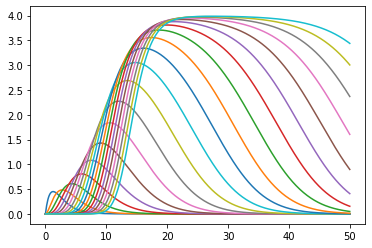

OK!


In [3]:


import matplotlib.pyplot as plt
import numpy as np
import modelbase
N=20

p = {'Lambda':1.,
                    'alpha':.1,
                    'beta':0.6,
                    'tot':10.,
                    #'C':10
                    }
cl=[]
for i in range(N):
    cl.append('X'+str(i))
    p['alpha'+str(i)]=p['alpha']
    p['beta'+str(i)]=p['beta']
    
m = modelbase.Model(p)



m.set_cpds(cl)

def module(par, y):
        return np.array([par.tot - y[0]])
m.add_algebraicModule(module, 'rapidEqx'+str(0),['X'+str(0)],['Xi'+str(0)])


def first_activation(p,X,Xi,**kwargs):
    return (p.__getattribute__('alpha'+str(0))*np.exp(-1*(p.Lambda) * kwargs['t']))*Xi
m.set_ratev('first_activation',first_activation,'X'+str(0),'Xi'+str(0))
m.set_stoichiometry('first_activation',{'X'+str(0):1})

def first_decay(p,X):
    return p.__getattribute__('beta'+str(0))*X

m.set_rate('first_decay',first_decay,'X'+str(0)) 
m.set_stoichiometry('first_decay',{'X'+str(0):-1}) 

for i in range(1,N):
    m.add_algebraicModule(module, 'rapidEqx'+str(i),['X'+str(i)],['Xi'+str(i)])

    def activation(p,X_1,X,Xi):
        return p.__getattribute__('alpha'+str(i))*X_1*Xi
    
    m.set_rate('act'+str(i),activation,'X'+str(i-1),'X'+str(i),'Xi'+str(i)) 
    m.set_stoichiometry('act'+str(i),{'X'+str(i):1})
    
    def decay(p,X):
        return p.__getattribute__('beta'+str(i))*X
    
    m.set_rate('decay'+str(i),decay,'X'+str(i)) 
    m.set_stoichiometry('decay'+str(i),{'X'+str(i):-1}) 



s = modelbase.Simulator(m)
s.timeCourse(np.linspace(0,50,500),np.zeros(N))

plt.figure()
for i in range(N):
    
    plt.plot(s.getT(),s.getVarByName('X'+str(i)))
plt.draw_if_interactive()
plt.show()

print("OK!")



## Labelings in a small system

We are going to implement a small metabolic model with two reactions. This system contains aldolase that combines Glyceraldehyde-3-phosphate (G3P) and Dihydroxyacetonephosphate (DHAP) to Fructose-1,6-bisphosphate (FBP) by "stacking" DHAP on top of G3P and Triosephosohate isomerase that converts G3P to DHAP, thereby swaping the first and the last atom.

The task is to implement above described system by using the "Labelmodels" from modelbase. 

\begin{equation}
G3P \rightarrow DHAP
\end{equation}

\begin{equation}
G3P + DHAP \rightarrow FBP
\end{equation}

- Use simple mass-action kinetics


- Use following parameters 

$k_{TPI-f}$ = 1.0, 

$K_{eq-TPI}$ = 21.0,

$k_{ALD-f}$ = 2000.0,

$K_{eq-Ald}$ = 7000.0.

- Use following initial concentrations:

G3P    = 2.5e-5

DHAP   = G3P * $K_{eq-TPI}$

FBP  = G3P * DHAP * $K_{eq-Ald}$

- Make simulations with following start labels:

1. G3P-C1
2. G3P-C3
3. G3P-C2
4. G3P-C1, DHAP-C3
5. FBP-C5

What do you observe?

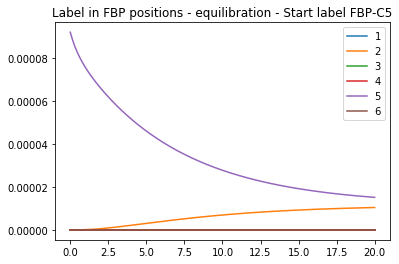

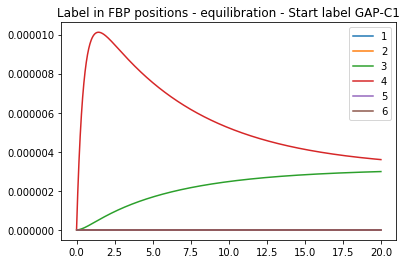

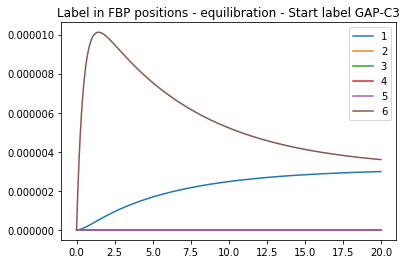

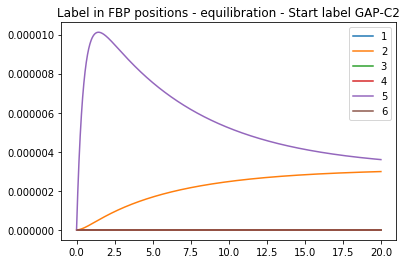

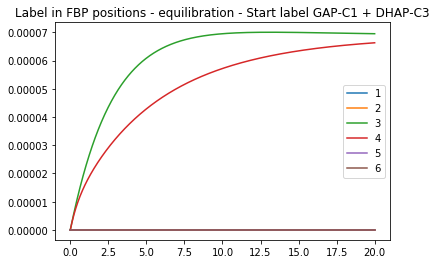

In [4]:
# instantiate model
m = modelbase.LabelModel()
    
#define parameters
m.par.update({'kf_TPI': 1.0,
              'Keq_TPI': 21.0,
              'kf_Ald': 2000.0,
              'Keq_Ald': 7000.0})
    
# set the 'base' compounds. Second argument defines numbers of carbons
# these will be automatically expanded into 8 (=2^3), 8, and 64 (=2^6) 
# isotope variants, respectively
m.add_base_cpd('GAP',3)
m.add_base_cpd('DHAP',3)
m.add_base_cpd('FBP',6)

# define a simple mass-action rate-law for the forward TPI reaction
# GAP -> DHAP
def v1f(p,y):
    return rl.massAction(p.kf_TPI,y)

# tell the model this is a carbon map reaction
# arguments:
# name, rate function, carbon map (here the numbers are reversed!),
# list of substrates, list of products, variables to be passed
m.add_carbonmap_reaction('TPIf',v1f,[2,1,0],['GAP'],['DHAP'],'GAP')

def v1r(p,y):
    return rl.massAction(p.kf_TPI/p.Keq_TPI,y)

m.add_carbonmap_reaction('TPIr',v1r,[2,1,0],['DHAP'],['GAP'],'DHAP')

def v2f(p,y,z):
    return rl.massAction(p.kf_Ald,y,z)

m.add_carbonmap_reaction('Aldf',v2f,[0,1,2,3,4,5],['DHAP','GAP'],['FBP'],'DHAP','GAP')

def v2r(p,y):
    return rl.massAction(p.kf_Ald/p.Keq_Ald,y)

m.add_carbonmap_reaction('Aldr',v2r,[0,1,2,3,4,5],['FBP'],['DHAP','GAP'],'FBP')

# set initial concentrations
GAP0 = 2.5e-5
DHAP0 = GAP0 * m.par.Keq_TPI
FBP0 = GAP0 * DHAP0 * m.par.Keq_Ald
y0d = {'GAP': GAP0,
       'DHAP': DHAP0,
       'FBP': FBP0}
    
# simulate equilibration of the labels
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'FBP':4})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0)
    
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration - Start label FBP-C5")
plt.show()
plt.draw_if_interactive()
    
# simulate equilibration of the labels
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'GAP':0})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0)
    
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration - Start label GAP-C1")
plt.show()
plt.draw_if_interactive()
    
# simulate equilibration of the labels
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'GAP':2})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0)
    
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration - Start label GAP-C3")
plt.show()
plt.draw_if_interactive()

# simulate equilibration of the labels
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'GAP':1})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0)
    
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration - Start label GAP-C2")
plt.show()
plt.draw_if_interactive()
    
    
# simulate equilibration of the labels
y0 = m.set_initconc_cpd_labelpos(y0d,labelpos={'GAP':0, 'DHAP':2})
s = modelbase.Simulator(m)
T = np.linspace(0,20,1000)
s.timeCourse(T,y0)
    
plt.figure()
plt.plot(s.getT(),np.vstack([s.getLabelAtPos('FBP',i) for i in range(6)]).transpose())
plt.legend([str(i+1) for i in range(6)])
plt.title("Label in FBP positions - equilibration - Start label GAP-C1 + DHAP-C3")
plt.show()
plt.draw_if_interactive()

## Bacterial Chemotaxis

A simple model of bacterial chemotaxis was presented in [Kollmann et al. (2005), Nature](https://doi.org/10.1038/nature04228). The model simulates the phosphorylation of the CheY protein in dependence on an external ligand concentration. The phosphorylation status of CheY determines the direction of the flagellar motor, and thus wether the bacterium is in 'swimming' or 'tumbling' mode. 

A key feature of the model (and the biological system) is its perfect adaptability. For constant ligand concentration, the CheY protein always reaches the same steady-state phosphorylation state. This is important, because changes in the motion should only be triggered upon changes in concentration. This remarkable feature leads to the ability to swim on average in the direction of nutrient gradient.

The model contains three variables:

$T_M$: the methylated receptor molecules
$A_p$: the phosphorylated Che-A proteins
$Y_p$: the phosphorylated Che-Y proteins

A particular feature is that the activity of the receptor (activating Che-A) is dependent on the ligand concentration. This means that the receptor becomes less sensitive if ligand concentration is high. This active fraction $T_A$ is calculated as

$T_A = p(L)T_M$ with $p(L) = V\left(1-\frac{L^H}{L^H+K^H}\right),$

where $L$ is the ligand concentration and $V$, $K$ and $H$ some constants.

Only the active form $T_A$ of the receptor is i) subject to deactivation and ii) activating Che-A.

The dynamics of the signalling cascade is described by the following system of differential equations:

$\frac{dT_M}{dt}=k_R R-k_B B^T\frac{T_A}{K_B+T_A}\\
\frac{dAp}{dt}=k_AT_A(A^T-Ap)-k_YAp(Y^T-Yp)\\
\frac{dYp}{dt}=k_YAp(Y^T-Yp)-\gamma_YYp.$
    
For the tutorial, use the following parameters:

$K=V=1$mM, and $H=1.2$.

Use the following concentrations (in $\mu\text{M}$): $R=0.16$, $A^T=5.3$, $B^T=0.28$, $Y^T=9.7$ and the rate
constants $k_R=0.5$, $k_B=16$, $k_A=50$, $k_Y=100$ (in $\mu\text{M}^{-1}\text{s}^{-1}$) and
$\gamma_Y=25\text{s}^{-1}$ and the Michaelis constant $K_B=16\mu\text{M}$.
Explore various time courses for the ligand concentration, e.g.

$ L(t)=\left\{
    \begin{array}{c@{\hspace{1em}}l}
      1 & 100<t<200\\
      0 & \text{else}
    \end{array}
  \right.
$

and plot the concentration of phosphorylated CheY ($Yp$) as a function of
time.


In [5]:
"""
Define model parameters as dictionary and chemical species as list
"""

par = {'K': 1,
       'V': 1,
       'H': 1.2,
       'R': 0.16,
       'AT': 5.3,
       'BT': 0.28,
       'YT': 9.7,
       'kR': 0.5,
       'kB': 16,
       'kA': 50,
       'kY': 100,
       'gammaY': 25,
       'KB': 16,
       'L': 0,
      }

cpd_list = ['TM','Ap','Yp']

In [6]:
"""
Instatiate modelbase object, called 'm'
"""

m = modelbase.Model(par)

In [7]:
"""
Define the compound names
"""

m.set_cpds(cpd_list)

In [8]:
"""
Define the active receptors TA as an algebraic module:
TA is derived from TM and the parameter L (and some others), but is used at various occurences. 
So it is useful to have access to this dependent variable.
"""

def TA(par,y):
    L = par.L
    H = par.H
    p = par.V * (1 - L**H / (L**H + par.K**H))
    return np.array([p * y[0]])

m.add_algebraicModule(TA,'TA',['TM'],['TA'])


In [9]:
"""
Now define all processes involved in the model:
- Receptor methylation and demethylation ('meth' and 'demeth')
- Activation of Che-A ('actA')
- Conversion of Che-Ap into Che-Yp (a phosphate group is transferred - 'actY')
- Deactivation of Che-Y ('deactY')
"""


m.add_reaction('meth', lambda p:p.kR * p.R, {'TM':1})

def demeth(par,TA):
    return par.kB * par.BT * TA/(par.KB + TA)

m.add_reaction('demeth', demeth, {'TM':-1}, 'TA')

def actA(par,TA,Ap):
    return par.kA * TA * (par.AT - Ap)

m.add_reaction('actA', actA, {'Ap':1}, 'TA', 'Ap')

def actY(par,Ap,Yp):
    return par.kY * Ap * (par.YT - Yp)

m.add_reaction('actY', actY, {'Ap':-1,'Yp':1}, 'Ap', 'Yp')

def deactY(par,Yp):
    return par.gammaY * Yp

m.add_reaction('deactY', deactY, {'Yp':-1}, 'Yp')

In [10]:
"""
Perform a simulation, where L=0 for 100s, L=1 for 100s and L=0 for 100s.
For this, create a Simulator instance.
Run three simulations with 'timeCourse', between which the parameter L (ligand) is changed.
"""

y0 = np.zeros(3)
s = modelbase.Simulator(m)
T = np.linspace(0,100,100)
s.timeCourse(T,y0)
m.par.L=1
s.timeCourse(T,None) # if initial values are 'None', the simulation continues from the last values.
m.par.L=0
s.timeCourse(T,None)

array([[0.58181778, 0.11291204, 3.01794001],
       [0.5183295 , 0.28986339, 5.2182172 ],
       [0.46460063, 0.23647821, 4.7241434 ],
       [0.42346294, 0.20120788, 4.33311115],
       [0.39200839, 0.1770619 , 4.02788173],
       [0.36798266, 0.16008315, 3.79156143],
       [0.34964601, 0.14790433, 3.60952874],
       [0.3356599 , 0.13903836, 3.46978553],
       [0.32499713, 0.13251257, 3.36275476],
       [0.31687094, 0.12766951, 3.28091175],
       [0.31067958, 0.12405296, 3.21840181],
       [0.30596337, 0.12133969, 3.17069846],
       [0.30237142, 0.11929692, 3.13431718],
       [0.29963604, 0.11775488, 3.10658357],
       [0.29755317, 0.11658846, 3.08544942],
       [0.29596727, 0.11570483, 3.06934849],
       [0.29475982, 0.11503465, 3.05708449],
       [0.29384055, 0.11452592, 3.04774443],
       [0.29314071, 0.11413947, 3.04063199],
       [0.29260793, 0.11384577, 3.03521633],
       [0.29220233, 0.11362247, 3.03109292],
       [0.29189356, 0.11345265, 3.02795357],
       [0.

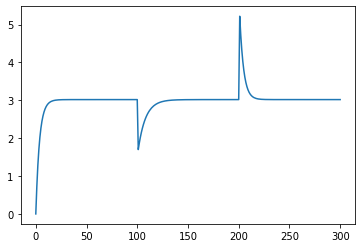

In [11]:
"""
Plot phosphorylated Che-Y (Yp) as a function of time
"""

plt.plot(s.getT(),s.getVarByName('Yp'))